## Heart rate estimation from Photoplethysmographic (PPG) signals

The advent of wearable devices has made it possible to monitor users heart rate in real time. Monitoring of HR can guide an athelete to adjust his/her training intensity, or enables monitoring users cardiac rhythum.

Most of the devices estimate heart rate (HR) using [Photoplethysmographic](https://en.wikipedia.org/wiki/Photoplethysmograph) PPG signals. The PPG signals are obtained using [pulse oximeters](https://en.wikipedia.org/wiki/Pulse_oximeter) which illumates users skin using a LED and measures the intensity changes in the light reflected from the skin. The intensity changes denotes the PPG signal. The periodicity of the PPG signal corresponds to the cardiac cycle and hence HR can be estimated using PPG signal.

In this notebook, I attempt to estimate HR from a set of data typically obtained from wearable devices. The set of data used in this notebook was made available as a part of [signal processing cup](http://www.signalprocessingsociety.org/spcup2015/index.html) organized during [ICASSP 2015](http://icassp2015.org).

### Experiment description and data format
The experiment used to collect the data is described [here](https://www.dropbox.com/s/kb8whcceih4mn03/Readme.pdf). The data was collected as a part of work done by the authors in [1]. I summarize the description below:

* Two-channel PPG signals, three-axis accelorometer signals and one-channel ECG signal (ground truth) were recorded from subjects.
* All signals were sampled at 125 Hz.
* Each dataset with similar name 'DATA_01_TYPE_01' contains a variable 'sig'. It has 6 rows. The first row is ECG signal, the second and third rows are two channel PPG and the last three rows are accelerometer data.

* The test subjects performed two activities
  * Activity **TYPE01**: rest(30s) -> 8km/h(1min) -> 15km/h(1min) -> 8km/h(1min) -> 15km/h(1min) -> rest(30s)
  * Activity **TYPE02**: rest(30s) -> 6km/h(1min) -> 12km/h(1min) -> 6km/h(1min) -> 12km/h(1min) -> rest(30s)
  * Each activity begins with a 30 sec rest followed by four 1 minute sessions of running activity and ends with another 30 secs of rest.

**Reference**

[1]: Z. Zhang, Z. Pi, B. Liu, **TROIKA: A general framework for heart rate monitoring using wrist-type photoplethysmographic signals during intensive physical exercise**, IEEE Transactions on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015, DOI: 10.1109/TBME.2014.2359372


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import loadmat
FREQ_SAMPLE = 125  

Lets begin by visualizing first data for Activity **TYPE01**. Using `loadmat` to read the data stored in MATLAB's .mat files. The `loadmat` function returns a `dict` type.

In [17]:
mat_data = loadmat('./training_data/DATA_01_TYPE01.mat')

In [18]:
mat_data.keys()

dict_keys(['__header__', '__version__', 'sig', '__globals__'])

In [51]:
data = mat_data['sig']  # Extract just the matrix
num_sig , num_sample = data.shape
print(num_sig, num_sample)

6 37937


So as expected the 'sig' matrix has 6 rows as described above and for each row there are 37937 samples. Lets visualize the ECG and PPG signal.

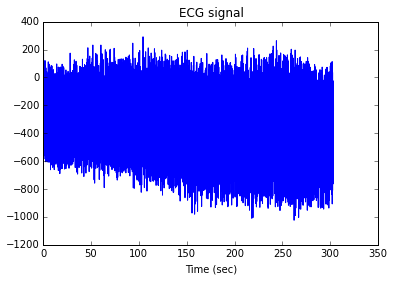

In [53]:
t = np.linspace(0, num_sample/FREQ_SAMPLE, num_sample)
plt.plot(t, data[0,:])
plt.title('ECG signal')
plt.xlabel('Time (sec)')
plt.xlim((0, 300))

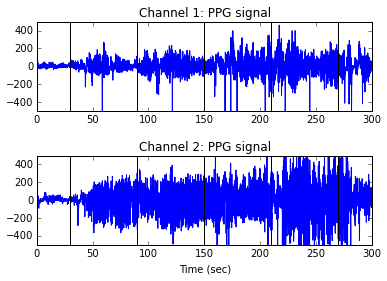

In [54]:
f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)
ax1.plot(t, data[1, :])
ax1.axvline(x = 30, color='k')
ax1.axvline(x = 90, color='k')
ax1.axvline(x = 150, color='k')
ax1.axvline(x = 210, color='k')
ax1.axvline(x = 270, color='k')
ax1.set_title('Channel 1: PPG signal')
ax1.set_xlim((0, 300))
ax1.set_ylim((-500, 500))

ax2.plot(t, data[2, :])
ax2.set_title('Channel 2: PPG signal')
ax2.set_xlabel('Time (sec)')

ax2.axvline(x = 30, color='k')
ax2.axvline(x = 90, color='k')
ax2.axvline(x = 150, color='k')
ax2.axvline(x = 210, color='k')
ax2.axvline(x = 270, color='k')
ax2.set_xlim((0, 300))
ax2.set_ylim((-500, 500))
f.subplots_adjust(hspace=0.5)


In the above plot, the vertical lines demarcate different activity intervals described above.

Now lets take a look at the calculated'ground true' BPM values estimated from the ECG signal. The ground truth values are stored in 'DATA_01_TYPE01_BPMtrace.mat' file. The BPM values are given for every 8-second time window. Also two successive time windows overlap by 6 seconds.

In [22]:
mat_bpm = loadmat('./training_data/DATA_01_TYPE01_BPMtrace.mat')
data_bpm = mat_bpm['BPM0']

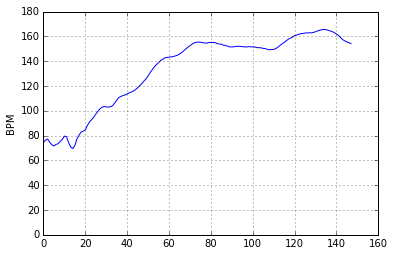

In [66]:
plt.plot(data_bpm)
plt.ylabel('BPM')
plt.ylim((0, 180))
plt.grid(True)

Now lets estimate the BPM HR using the Channel 1 PPG signal above. For starters, I will be using a very crude approach of Welch power spectral estimator to estimate the HR.

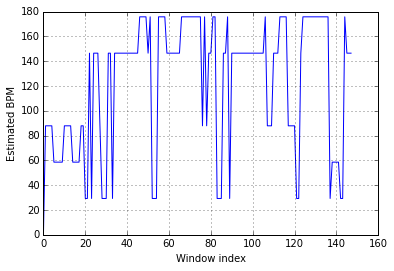

In [70]:
import scipy.signal as signal # Signal processing module
# Load data
window = 8*FREQ_SAMPLE
step = 2*FREQ_SAMPLE
window_number = int((num_sample - window)/step + 1) # Total number of windows 
# Estimate HR for each window
estimate_hr = np.zeros((window_number, 1))
for idx in np.arange(1, window_number):
    segment_cur = data[1, (idx - 1)*step + 1 : (idx - 1)*step + window]
    f, Pwelch_spec = signal.welch(segment_cur, FREQ_SAMPLE, window='hanning', scaling='spectrum')
    estimate_hr[idx] = f[Pwelch_spec == np.max(Pwelch_spec)] #freq corresp to peak power is the estimate

estimate_bpm = estimate_hr*60
plt.plot(estimate_bpm)
plt.xlabel('Window index')
plt.ylabel('Estimated BPM')
plt.ylim((0, 180))
plt.grid(True)

As expected, the BPM estimates using the crude approach exhibit significant variation. Comparing the crude estimate does show some similarity with the ground truth data. For the initial 30 seconds, the estimates are low values in the range of 60 - 80 BPM, which makes sense since the subjects are in rest. Beyond the first 30 secs, there is increase in BPM as the subjects start to exercise. But due to the crude nature of estimation, we see significant variations in the estimate. 

**Next step is to improve the HR estimator, possibly use the TROIKA approach**